# RNN - 预测正弦函数
+ 参考《TensorFlow实战Google深度学习框架》。不使用TFLearn，只使用TensorFlow
+ 完整代码看[这里]()

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 数据准备

In [2]:
# 训练数据个数
training_examples = 10000
# 测试数据个数
testing_examples = 1000
# sin函数的采样间隔
sample_gap = 0.01
# 每个训练样本的长度
timesteps = 20

In [3]:
def generate_data(seq):
    '''
    生成数据，seq是一序列的连续的sin的值
    '''
    X = []
    y = []
    
    # 用前 timesteps 个sin值，估计第 timesteps+1 个
    # 因此， 输入 X 是一段序列，输出 y 是一个值 
    for i in range(len(seq) - timesteps -1):
        X.append(seq[i : i+timesteps])
        y.append(seq[i+timesteps])
        
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    

In [4]:
test_start = training_examples*sample_gap
test_end = test_start + testing_examples*sample_gap

train_x, train_y = generate_data( np.sin( np.linspace(0, test_start, training_examples) ) )
test_x, test_y = generate_data( np.sin( np.linspace(test_start, test_end, testing_examples) ) )

## 建立RNN模型

### 设置模型参数

In [5]:
lstm_size = 30
lstm_layers = 2
batch_size = 64

### 定义输入输出

In [6]:
x = tf.placeholder(tf.float32, [None, timesteps, 1], name='input_x')
y_ = tf.placeholder(tf.float32, [None, 1], name='input_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### 建立LSTM层

In [8]:
# 有lstm_size个单元
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# 添加dropout
drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
# 一层不够，就多来几层
def lstm_cell():
    return tf.contrib.rnn.BasicLSTMCell(lstm_size)
cell = tf.contrib.rnn.MultiRNNCell([ lstm_cell() for _ in range(lstm_layers)])

# 进行forward，得到隐层的输出
outputs, final_state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
# 在本问题中只关注最后一个时刻的输出结果，该结果为下一个时刻的预测值
outputs = outputs[:,-1]

# 定义输出层, 输出值[-1,1]，因此激活函数用tanh
predictions = tf.contrib.layers.fully_connected(outputs, 1, activation_fn=tf.tanh)
# 定义损失函数
cost = tf.losses.mean_squared_error(y_, predictions)
# 定义优化步骤
optimizer = tf.train.AdamOptimizer().minimize(cost)

### 训练

In [9]:
# 获取一个batch_size大小的数据
def get_batches(X, y, batch_size=64):
    for i in range(0, len(X), batch_size):
        begin_i = i
        end_i = i + batch_size if (i+batch_size) < len(X) else len(X)
        
        yield X[begin_i:end_i], y[begin_i:end_i]

In [18]:
epochs = 20
session = tf.Session()
with session.as_default() as sess:
    # 初始化变量
    tf.global_variables_initializer().run()
    
    iteration = 1
    
    for e in range(epochs):
        for xs, ys in get_batches(train_x, train_y, batch_size):
            # xs[:,:,None] 增加一个维度，例如[64, 20] ==> [64, 20, 1]，为了对应输入
            # 同理 ys[:,None]
            feed_dict = { x:xs[:,:,None], y_:ys[:,None], keep_prob:.5 }
        
            loss, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        
            if iteration % 100 == 0:
                print('Epochs:{}/{}'.format(e, epochs),
                      'Iteration:{}'.format(iteration),
                      'Train loss: {:.8f}'.format(loss))
            iteration += 1

Epochs:0/20 Iteration:100 Train loss: 0.01009926
Epochs:1/20 Iteration:200 Train loss: 0.02012673
Epochs:1/20 Iteration:300 Train loss: 0.00237983
Epochs:2/20 Iteration:400 Train loss: 0.00029798
Epochs:3/20 Iteration:500 Train loss: 0.00283409
Epochs:3/20 Iteration:600 Train loss: 0.00115144
Epochs:4/20 Iteration:700 Train loss: 0.00130756
Epochs:5/20 Iteration:800 Train loss: 0.00029282
Epochs:5/20 Iteration:900 Train loss: 0.00045034
Epochs:6/20 Iteration:1000 Train loss: 0.00007531
Epochs:7/20 Iteration:1100 Train loss: 0.00189699
Epochs:7/20 Iteration:1200 Train loss: 0.00022669
Epochs:8/20 Iteration:1300 Train loss: 0.00065262
Epochs:8/20 Iteration:1400 Train loss: 0.00001342
Epochs:9/20 Iteration:1500 Train loss: 0.00037799
Epochs:10/20 Iteration:1600 Train loss: 0.00009412
Epochs:10/20 Iteration:1700 Train loss: 0.00110568
Epochs:11/20 Iteration:1800 Train loss: 0.00024895
Epochs:12/20 Iteration:1900 Train loss: 0.00287319
Epochs:12/20 Iteration:2000 Train loss: 0.00012025
Epoc

### 测试

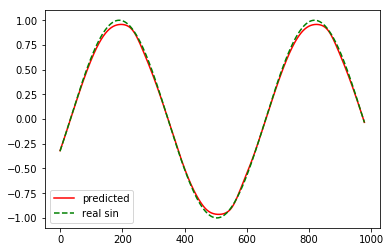

In [19]:
with session.as_default() as sess:
    ## 测试结果
    feed_dict = {x:test_x[:,:,None], keep_prob:1.0}
    results = sess.run(predictions, feed_dict=feed_dict)
    plt.plot(results,'r', label='predicted')
    plt.plot(test_y, 'g--', label='real sin')
    plt.legend()
    plt.show()